In [1]:
"""
Script to load raw drifter data from the SIO url

Creates data files with a netcdf xarray object, called pidXXXXXXXXX.nc
If the script is re-run when output files already exist, it attempts
to append the files with new data.

Takes user inputs in download_config.yml and requires a list of platform ids in PID_list.txt

"""

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import requests
import yaml
import os
import glob
import re
#import sys
import datetime
from datetime import timedelta
from io import StringIO
#from bs4 import BeautifulSoup

# Local import 
# > Make sure SIO_wrap dir is on the same path as this script.
%load_ext autoreload
%autoreload 2
from SIO_wrap import dir_tree, fnames

from setdir import *

/Users/eddifying/Python/drifters/ already exists
/Users/eddifying/Python/drifters/02-code/ already exists
/Users/eddifying/Python/drifters/02-code/SIO_wrap/ already exists
/Users/eddifying/Python/drifters/01-data/04-aux/ already exists
/Users/eddifying/Python/drifters/01-data/02-intermediate/ already exists


In [2]:
def load_one_drifter(pidstr, dnld_config, download_start_date): 
    
    from SIO_wrap import fnames
    
    #--------------------------------
    # Configuration details
    #--------------------------------
    base_url = dnld_config['base_url']
    username = dnld_config['username']
    password = dnld_config['password']
    
    tstr = f'start_date={download_start_date}'
    pidwrapstr = '&platform_id='

    full_url = base_url+tstr+pidwrapstr+pidstr

    #--------------------------------
    # Request file
    #--------------------------------
    resp = requests.get(full_url, auth=(username, password))
    # Print the response code (200 is good. If you get something else, may be
    # a password problem)

    # To print content: resp.content
    aa = resp.content.decode("utf-8")
    data_df = pd.read_csv(StringIO(aa))
    
    #--------------------------------
    # Clean up column names
    #--------------------------------
    tmp = data_df.columns.str.strip()
    tmp = tmp.str.replace(" ", "", regex=True)
    tmp = tmp.str.replace("-", "_", regex=True)
    tmp = tmp.str.replace("(", "_", regex=True)
    tmp = tmp.str.replace(')', '', regex=True)
    data_df.columns = tmp
    
    #--------------------------------
    # Remove the </br> column (IF IT EXISTS)
    #--------------------------------
    if '</br>' in data_df.columns:
        data_df = data_df.drop(columns='</br>')
        # data_df.dtypes
    
    #--------------------------------
    # Convert the time column to a timestamp
    #--------------------------------
    time_colname = 'Timestamp_UTC'
    data_df[time_colname] = pd.to_datetime(data_df[time_colname],
                                       format=timcol_strftime) 
    
    # Prep to convert xarray
    data_df2 = data_df
    data_df2["time"] = data_df2["Timestamp_UTC"].values
    data_df2 = data_df2.set_index("time")
    data_df2 = data_df2.drop(columns='Timestamp_UTC')
    #--------------------------------
    # Convert to xarray
    #--------------------------------
    ds = data_df2.to_xarray()

    # Sort by time ascending
    ds = ds.sortby('time', ascending=True)

    return ds


In [3]:
with open('download_config.yml') as f:
    dnld_config = yaml.safe_load(f)

# Download start date must have format yyyy-mm-dd. Default is set to the
# beginning of the TERIFIC project, i.e 2019-12-04.
download_start_date = dnld_config['download_start_date']
print("\nDefault download start date: %s\n" % download_start_date)

# How many data points need to be available in order to update the data file?
# For hourly data, 24 data points is a full day.
num_update = dnld_config['num_update']

if 0:
    keyslist = list(dnld_config.keys())
    for keyname in keyslist:
        print(dnld_config[keyname])
        tmp = dnld_config[keyname]
        print(type(tmp))
        exec(keyname+'='+tmp)

    


Default download start date: 2019-12-04



In [4]:
# Path where data are saved. Can be changed in file SIO_wrap/dir_tree.py
data_dir = dir_tree.dir_out

# String formatting for time for:
#   - the download url, 
#   - appending to the filename
# 	- the data time column, respectively.
url_strf = '%Y-%m-%d'
tstamp_strf = '%Y%m%d'
mtime_strf = '%Y-%m-%dT%H:%M:%S'
timcol_strftime = '%Y-%m-%d %H:%M:%S'

# Get the list of Platform IDs
PID = pd.read_csv(cat_proc_path('PID_list.txt'), header='infer', index_col=0)


In [99]:
# Compare when the file was last updated to now
todaystr = datetime.datetime.now().strftime(url_strf)
                       
counter = 0
#4 and 57
#------------------------------------------------------------------------
# Loop through all the PID in TERIFIC
#------------------------------------------------------------------------
for i in range(57,len(PID)):
    # Get a single platform ID from the full list
    PID1 = (PID["PID"].values)[i]
    pidstr = PID1.astype('str')
    print(str(counter)+'. '+pidstr)

    # Use the same file name with just pid and then the PID
    fname = 'pid'+str(PID1)+'*.nc'
    existing_files = glob.glob(cat_raw_path(fname))

    #------------------------------------------------------
    # If there are no existing data files, then download
    # all data and save to netcdf
    #------------------------------------------------------
    if (len(existing_files)==0) | (PID1==300234068342280):
        print('       - no existing files')
        ds_new = load_one_drifter(pidstr, dnld_config,
                                  download_start_date)
        #------------------------------------------------------
        # Create the attributes
        maxtime = ds_new.time.max().values
        maxtimestr = pd.to_datetime(maxtime).strftime(mtime_strf)
        
        PID1_from_data = ds_new.Platform_ID.values[-1]
        pidstr_from_data = PID1_from_data.astype('str')
        if not PID1_from_data==PID1:
            print('========== PID mismatch: '+pidstr+'~='+pidstr_from_data)
        attr_dict = {"Platform_ID": PID1_from_data,
                    "End Time": maxtimestr,
                    "Project": dnld_config['project_name'],
                    "Originator": dnld_config['operator_name'],
                    "Institution": dnld_config['institution_name'],
                    "Date created": todaystr,
                    }

        ds_new = ds_new.assign_attrs(attr_dict)

        #------------------------------------------------------
        # Save file to raw 
        fname = 'pid'+pidstr_from_data+'.nc'
        outfile_with_path = cat_raw_path(fname)
        ds_new.to_netcdf(cat_raw_path(fname), mode='w')
        print(str(counter)+'. pid('+pidstr_from_data+
              ') - New end:'+maxtimestr)
        print('---- PID: '+str(PID1_from_data)+' and filename: '+fname)
        counter += 1
        
    #------------------------------------------------------
    # If there are existing data files, check whether it
    # needs to be updated - download and append
    #------------------------------------------------------
    if len(existing_files) > 0:

        #------------------------------------------------
        # Load the newest file in the list
        latest_file = max(existing_files, key=os.path.getctime)
        ds_previous = xr.open_dataset(latest_file)
        PID1_from_data = ds_previous.attrs['Platform_ID']
        if not PID1_from_data==PID1:
            print('--------- MISMATCH: PID and ds_previous')

        #------------------------------------------------
        # Check whether the file needs to be updated
        maxtimestr_prev = ds_previous.attrs['End Time']
        maxtime_prev = datetime.datetime.strptime(maxtimestr_prev, mtime_strf)
        # End date (without time)
        download_update = maxtime_prev.strftime(url_strf)
        print('       - existing files, ending '+download_update)
        

        #------------------------------------------------
        # If the last date is the same as today, then do not proceed
        if not todaystr==download_update:
            #------------------------------------------------
            # Download drifter data since the previous date
            ds_update = load_one_drifter(pidstr, dnld_config, download_update)

            # If there were at least 24 data points since the last data file,
            # then append the PID to the update list
            if len(ds_update["time"]) > num_update:
                print('       - new data '+str(len(ds_update["time"])))

                # Remove platform ID as a long DataArray - 
                # it's now an attribute
#                ds_update = ds_update.drop('Platform_ID')
                PID1_from_data = ds_update.Platform_ID.values[-1]
                pidstr_from_data = PID1_from_data.astype('str')
                if not PID1_from_data==PID1:
                    print('========== PID mismatch: '
                          +pidstr+'~='+pidstr_from_data)


                # Merge the old and new data
                ds_new = xr.merge([ds_update, ds_previous], 
                                  combine_attrs="drop")

                #------------------------------------------------------
                # Create the attributes
                maxtime = ds_update.time.max().values
                maxtimestr = pd.to_datetime(maxtime).strftime(mtime_strf)

                attr_dict = {"Platform_ID": PID1,
                            "End Time": maxtimestr,
                            "Project": dnld_config['project_name'],
                            "Originator": dnld_config['operator_name'],
                            "Institution": dnld_config['institution_name'],
                            "Date created": todaystr,
                            }

                ds_new = ds_new.assign_attrs(attr_dict)

                #------------------------------------------------------
                # Save file to raw 
                fname = 'pid'+pidstr+'.nc'

                outfile_with_path = cat_raw_path(fname)
                print(getpass.getuser())
                ds_new.to_netcdf(cat_raw_path(fname), mode='w')
                print(str(counter)+'. pid('+pidstr+') - Ended:'\
                      +download_update
                      +', New end:'+maxtimestr)
                counter += 1
            else:
                print('       - no new data')




print('No more files to update')

0. 300234066513050
       - no existing files
0. pid(300234066513050) - New end:2022-01-01T15:00:00
---- PID: 300234066513050 and filename: pid300234066513050.nc
1. 300234068343450
       - existing files, ending 2021-02-26
       - no new data
1. 300234068346010
       - existing files, ending 2022-02-02
1. 300234066512030
       - existing files, ending 2021-02-14
       - no new data
1. 300234066511010
       - existing files, ending 2020-12-06
       - no new data
1. 300234068343970
       - existing files, ending 2022-02-03
       - no new data
1. 300234066513060
       - existing files, ending 2022-02-02
1. 300234068343460
       - existing files, ending 2021-03-24
       - no new data
1. 300234066512040
       - existing files, ending 2021-02-21
       - no new data
1. 300234068342440
       - existing files, ending 2021-02-07
       - no new data
1. 300234066416810
       - existing files, ending 2022-02-02
1. 300234066511020
       - existing files, ending 2021-05-16
       - 

loop PID       = 300234068342280
latest file.   = ../01-data/01-raw/pid300234068342280.nc
ds_previous.PID= 300234068342270
ds_update.PID  = 300234068342280


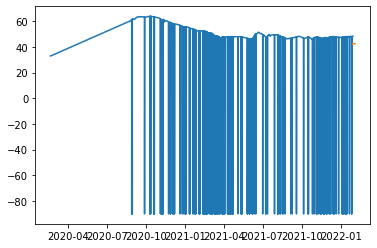

In [72]:
ds_previous = xr.open_dataset(latest_file)
print('loop PID       = '+pidstr)
print('latest file.   = '+latest_file)
print('ds_previous.PID= '+ds_previous.attrs["Platform_ID"].astype('str'))

# Check conflicting GPS values?
plt.plot(ds_previous["time"],ds_previous[latname])
plt.plot(ds_update["time"],ds_update[latname])
print('ds_update.PID  = '+ds_update.Platform_ID.values[-1].astype('str'))

In [93]:
import os, getpass
getpass.getuser()

'eddifying'

In [67]:
# Check PID in the data files
counter = 0
for i in range(len(PID)):
    
    # Get a single platform ID from the full list
    PID1 = (PID["PID"].values)[i]
    pidstr = PID1.astype('str')

    # Use the same file name with just pid and then the PID
    fname = 'pid'+str(PID1)+'*.nc'
    existing_files = glob.glob(cat_raw_path(fname))

    #------------------------------------------------------
    # If there are existing data files, check whether it
    # needs to be updated - download and append
    #------------------------------------------------------
    if len(existing_files) > 0:
        #------------------------------------------------
        # Load the newest file in the list
        latest_file = max(existing_files, key=os.path.getctime)
        ds_previous = xr.open_dataset(latest_file)
        pidcheck = ds_previous.attrs['Platform_ID']
        
        if not str(pidcheck)==pidstr:
            counter += 1
            print(str(counter)+'. '+latest_file+': '+str(pidcheck)+'==?'+pidstr)
    
    
        




1. ../01-data/01-raw/pid300234068342280.nc: 300234068342270==?300234068342280


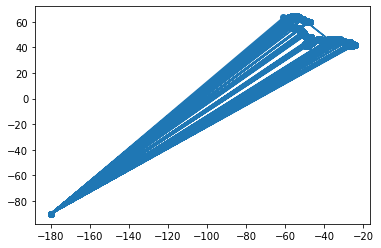

In [41]:
lonname='GPS_Longitude_deg'
latname='GPS_Latitude_deg'
plt.plot(ds_new[lonname],ds_new[latname],marker='o')